In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

## Binary Decision Tree Implementation

#### methods:
learn(X,y,impurity measure = 'entropy', pruning = False)<br>
>X is data matrix in the form of a pandas DataFrame<br>
>y is a vector of labels in the form of a pandas DataFrame<br>
>impurity measure can be 'entropy' or 'gini'<br>
>pruning accepts True or False<br>
>returns: None; head of decision tree is stored in 'head' instance variable of the object<br>

predict(x,head = None)<br>
>x can be a single vector or a data matrix in the form of a pandas DataFrame<br>
>head is an optional parameter to pass the head of a tree which is different from the one stored by the object
>returns: DataFrame with predicted labels of input<br>

get_stats(X = None, y = None)<br>
>X is a data matrix (in the form of a DataFrame) that you would like to test the model's performance on<br>
>y is the label vector<br>
>if X and y are not passed as parameters then it will calculate stats based off of the training data<br>
>returns: DataFrame with accuracy, recall, precision columns<br>

In [20]:
#binary decision tree implementation
class Tree():
    def __init__(self,name):
        #instance variables
        self.name = name #name of the model
        self.head = None #head node of the tree
        self.X_training = None #store data that the model is trained on
        self.y_training = None #^
    def __str__(self): #to print some kind of representation of the tree- it's not pretty though
        return f'Head: {self.head}'
    
    #classes for construction of tree
    class Node():
            def __init__(self,dec_key,dec_val):
                self.dec_key = dec_key
                self.dec_val = dec_val
            def __str__(self):
                return f'Decision key: {self.dec_key}, Desicion value: {self.dec_val}\n \tless than: {self.left_branch}\n \tgreater than: {self.right_branch}'
            def set_right(self,next):
                self.right_branch = next
            def set_left(self,next):
                self.left_branch = next
            def set_prev(self,prev):
                self.prev = prev
            pass
    class Leaf():
        def __init__(self,val):
            self.val = val
            pass
        def __str__(self):
            return f'Leaf value: {self.val}'
        def set_prev(self,prev):
            self.prev = prev
        pass

    def __impurity(self,X,y,impurity_measure):
        impurity_list = []
        for key in X.keys():
            split = np.mean(X[key])
            X_split = X[key] < split
            impurity = 0
            for value in X_split.unique():
                prob_X = X_split.value_counts()[value]/len(X_split)
                if impurity_measure == 'gini':
                    impurity += prob_X
                column = y.keys()[-1]
                for label in y[column].unique():
                    try:
                        prob_y_cond = (((X_split == value)&(y[column] == label)).value_counts()[True]/len(X_split))/prob_X
                    except:
                        impurity_list.append(0)
                        continue
                    if impurity_measure == 'entropy':
                        impurity -= prob_X * prob_y_cond * np.log2(prob_y_cond)
                    elif impurity_measure == 'gini':
                        impurity -= prob_X * (prob_y_cond**2)
            impurity_list.append(impurity)
        impurity_list = np.array(impurity_list)
        return impurity_list

    def __choose_split(self,X,y,impurity_measure):
        #calculate either conditional entropy or gini index
        impurity_array = self.__impurity(X,y,impurity_measure)
        if impurity_array.all() == 0:
            return self.Leaf(y[y.keys()[-1]].value_counts().keys()[0])
        #return the index of smallest value as this will result in the highest information gain
        return np.argmin(impurity_array)

    def learn(self,X,y,impurity_measure = 'entropy',pruning = False):
        if pruning:
            X_training,X_pruning,y_training,y_pruning = model_selection.train_test_split(X,y,train_size=0.5,test_size=0.5)
            self.head = self.__learn_recursive(X_training,y_training,impurity_measure)
            self.X_training = X.reset_index(drop = True)
            self.y_training = y.reset_index(drop = True)
            self.head = self.__prune(X_pruning,y_pruning,self.head)
        else:
            self.X_training = X.reset_index(drop = True)
            self.y_training = y.reset_index(drop = True)
            self.head = self.__learn_recursive(X,y,impurity_measure)

    def __learn_recursive(self,X,y,impurity_measure,prev = None):
        #check if all labels are the same; return leaf of that value if they are
        column = y.keys()[-1]
        if len(y[column].unique()) == 1:
            branch = self.Leaf(y[column].iloc[0])
            branch.set_prev(prev)
            return branch
        #check if all data values are the same and return most common label if true
        data_is_equal = True
        for key in X.keys():
            if len(X[key].unique()) == 1:
                continue
            else:
                data_is_equal = False
        if data_is_equal:
            branch = self.Leaf(y[column].value_counts().keys()[0])
            branch.set_prev(prev)
            return branch
        
        #find split with most information gain and split data to left and right branches
        else:
            split_index = self.__choose_split(X,y,impurity_measure)
            if isinstance(split_index,self.Leaf):
                split_index.set_prev(prev)
                return split_index
            split_key = X.keys()[split_index]
            split_value = np.mean(X[split_key])
            branch = self.Node(split_key,split_value)
            branch.set_prev(prev)
            branch.set_left(self.__learn_recursive(X[X[split_key] < split_value],y[X[split_key] < split_value],impurity_measure))
            branch.set_right(self.__learn_recursive(X[X[split_key] >= split_value],y[X[split_key] >= split_value],impurity_measure))
            return branch

    def predict(self,x,head = None):
        results = []
        for index, value in x.iterrows():
            if head is None:
                pointer = self.head
            else:
                pointer = head
            while not isinstance(pointer,self.Leaf):
                dec_val = pointer.dec_val
                dec_key = pointer.dec_key
                if value[dec_key] < dec_val:
                    pointer = pointer.left_branch
                else:
                    pointer = pointer.right_branch
            results.append(pointer.val)
        return pd.DataFrame({"type":results})
    
    def get_stats(self,X = None, y = None):
        if X is None and y is None:
            X,y, = self.X_training,self.y_training
        elif X is None or y is None:
            print('must give both X and y datasets')
            return
        y = y.reset_index(drop = True)
        y_predict = self.predict(X)
        accuracy = ((y_predict == y).value_counts()[True])/len(y)
        recall = (y_predict & y).value_counts()[1]/y.value_counts()[1]
        precision = (y_predict & y).value_counts()[1]/y_predict.value_counts()[1]
        return pd.DataFrame({'accuracy': [accuracy],'precision':[precision],'recall':recall},index = [self.name])
    
    def __prune(self,X,y,head):
        if isinstance(head,self.Leaf):
            return head
        head.set_right(self.__prune(X,y,head.right_branch))
        head.set_left(self.__prune(X,y,head.left_branch))
        subtree_accuracy = ((self.predict(X,head) == y.reset_index(drop = True)).value_counts()[True])/len(y)
        majority_label = y[y.keys()[-1]].value_counts().keys()[0]
        replacement_accuracy = (y == majority_label).value_counts()[True]/len(y)
        if subtree_accuracy >= replacement_accuracy:
            return head
        else:
            return self.Leaf(majority_label)
        
    

### Model Training

In [21]:
#load data into pandas dataframes
df = pd.read_csv("wine_dataset.csv")
X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
#split data into training, validation, and test sets
#figure out how to set random seed
seed = np.random.seed()
X_training,X_val_test,y_training,y_val_test = model_selection.train_test_split(X,y,train_size = 0.7,test_size=0.3,random_state=seed)
X_validation,X_test,y_validation,y_test = model_selection.train_test_split(X_val_test,y_val_test,train_size = 0.5,test_size=0.5,random_state=seed)
#training of 4 different models
model_0 = Tree("model_0: entropy, no pruning")
model_0.learn(X_training,y_training)

model_1 = Tree("model_1: gini index, no pruning")
model_1.learn(X_training,y_training,impurity_measure = 'gini')

model_2 = Tree("model_2: entropy, pruning")
model_2.learn(X_training,y_training,pruning = True)

model_3 = Tree("model_3: gini index, pruning")
model_3.learn(X_training,y_training,impurity_measure = 'gini',pruning = True)

### Model Evaluation and Selection

Training statistics:
                                  accuracy  precision    recall
model_0: entropy, no pruning     0.902592   0.886054  0.925400
model_1: gini index, no pruning  0.903038   0.888794  0.922735
model_2: entropy, pruning        0.819929   0.889968  0.732682
model_3: gini index, pruning     0.827971   0.893730  0.746892 

Validation statistics:
                                  accuracy  precision    recall
model_0: entropy, no pruning     0.897917   0.873950  0.916300
model_1: gini index, no pruning  0.891667   0.872340  0.903084
model_2: entropy, pruning        0.814583   0.879121  0.704846
model_3: gini index, pruning     0.812500   0.870270  0.709251 



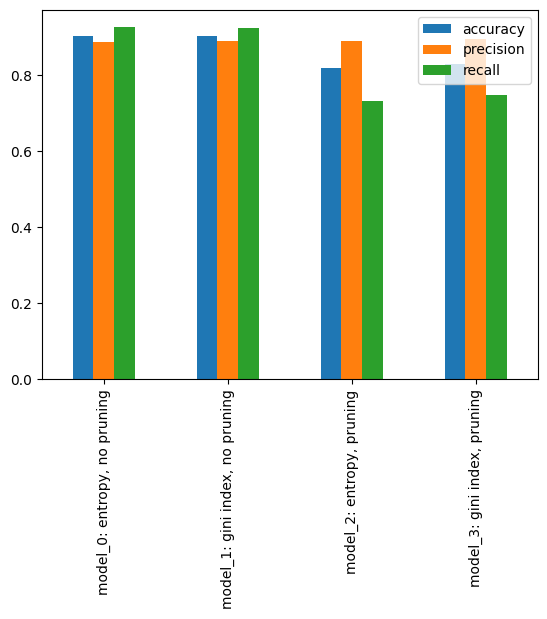

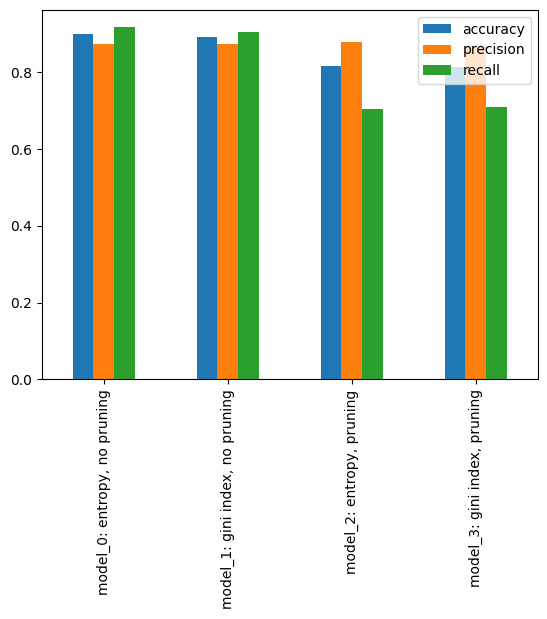

In [22]:
model_0_training_stats = model_0.get_stats()
model_0_validation_stats = model_0.get_stats(X_validation,y_validation)

model_1_training_stats = model_1.get_stats()
model_1_validation_stats = model_1.get_stats(X_validation,y_validation)

model_2_training_stats = model_2.get_stats()
model_2_validation_stats = model_2.get_stats(X_validation,y_validation)

model_3_training_stats = model_3.get_stats()
model_3_validation_stats = model_3.get_stats(X_validation,y_validation)

training_stats = pd.concat([model_0_training_stats,model_1_training_stats,model_2_training_stats,model_3_training_stats])
validation_stats = pd.concat([model_0_validation_stats,model_1_validation_stats,model_2_validation_stats,model_3_validation_stats])

training_stats.plot(kind = 'bar')
print('Training statistics:\n',training_stats,'\n')
validation_stats.plot(kind = 'bar')
print('Validation statistics:\n',validation_stats,'\n')

### Model Testing and comparison with SKLearn implementation

my model accuracy: 0.8895833333333333
sklearn entropy model accuracy: 0.8916666666666667
sklearn gini model accuracy: 0.9083333333333333


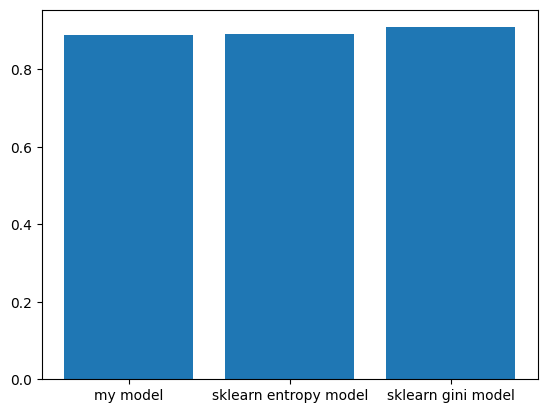

In [30]:
from sklearn import tree
skl_tree_gini = tree.DecisionTreeClassifier(criterion='gini')
skl_tree_entropy = tree.DecisionTreeClassifier(criterion='entropy')

skl_tree_gini.fit(X_training,y_training)
skl_tree_entropy.fit(X_training,y_training)

test_model_stats = model_0.get_stats(X_test,y_test)
test_model_accuracy = test_model_stats['accuracy'].iloc[0]

skl_tree_gini_predictions = skl_tree_gini.predict(X_test)
good_train_predictions = (skl_tree_gini_predictions == y_test['type'])
skl_gini_accuracy = np.sum(good_train_predictions)/len(y_test)

skl_tree_entropy_predictions = skl_tree_entropy.predict(X_test)
good_train_predictions = (skl_tree_entropy_predictions == y_test['type'])
skl_entropy_accuracy = np.sum(good_train_predictions)/len(y_test)

print(f'my model accuracy: {test_model_accuracy}\nsklearn entropy model accuracy: {skl_entropy_accuracy}\nsklearn gini model accuracy: {skl_gini_accuracy}')
plt.bar(["my model","sklearn entropy model","sklearn gini model"],[test_model_accuracy,skl_entropy_accuracy,skl_gini_accuracy])
plt.show()
